# Data 144 Final Project - MLPRegressor

Keilyn Yuzuki

Data Source: https://www.kaggle.com/mariaren/covid19-healthy-diet-dataset

**Question:** Can we accurately predict COVID-19 Death rates from diet?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, normalize
from sklearn.feature_extraction import DictVectorizer

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, ParameterGrid

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
plt.rcParams.update({'font.size': 16})

## Data Cleaning
Combining the 4 individual datasets into one.

Things to note:
- the columns `obesity`, `undernourished`, `confirmed`, `deaths`, `recovered`, `active`, `population`, and `unit_all_except_population` are the same between all 4 tables. In the final dataframe only one copy of these columns is retained.

In [2]:
def clean_column_names(df):
    old_names = df.columns
    new_names = df.columns.str.lower().str.replace(' -', '').str.replace(',','').str.replace('(','').str.replace(')','').str.replace(' ','_')
    name_dict = {}
    for a,b in zip(old_names, new_names):
        name_dict[a] = b
    df = df.rename(columns=name_dict)
    return df    

In [3]:
def load_clean_data(file, ignore_covid_stats=True):
    df = pd.read_csv(file)
    df = clean_column_names(df)
    if ignore_covid_stats:
        df = df.drop(['obesity', 'undernourished', 'confirmed', 'deaths', 'recovered', 'active', 'population', 'unit_all_except_population'], axis=1)
    return df
        

In [4]:
food_kcal = load_clean_data('data/Food_Supply_kcal_Data.csv')
food_kg = load_clean_data('data/Food_Supply_Quantity_kg_Data.csv')
fat = load_clean_data('data/Fat_Supply_Quantity_Data.csv')
protein = load_clean_data('data/Protein_Supply_Quantity_Data.csv', ignore_covid_stats=False)

food = food_kcal.merge(food_kg, how='inner', on='country', suffixes=['_food_kcal', '_food_kg'])
fat_protein = fat.merge(protein, how='inner', on='country', suffixes=['_fat', '_protein'])
combined = food.merge(fat_protein, how='inner', on='country')
combined.head()

,country,alcoholic_beverages_food_kcal,animal_products_food_kcal,animal_fats_food_kcal,aquatic_products_other_food_kcal,cereals_excluding_beer_food_kcal,eggs_food_kcal,fish_seafood_food_kcal,fruits_excluding_wine_food_kcal,meat_food_kcal,milk_excluding_butter_food_kcal,miscellaneous_food_kcal,offals_food_kcal,oilcrops_food_kcal,pulses_food_kcal,spices_food_kcal,starchy_roots_food_kcal,stimulants_food_kcal,sugar_crops_food_kcal,sugar_&_sweeteners_food_kcal,treenuts_food_kcal,vegetal_products_food_kcal,vegetable_oils_food_kcal,vegetables_food_kcal,alcoholic_beverages_food_kg,animal_fats_food_kg,animal_products_food_kg,aquatic_products_other_food_kg,cereals_excluding_beer_food_kg,eggs_food_kg,fish_seafood_food_kg,fruits_excluding_wine_food_kg,meat_food_kg,milk_excluding_butter_food_kg,miscellaneous_food_kg,offals_food_kg,oilcrops_food_kg,pulses_food_kg,spices_food_kg,starchy_roots_food_kg,stimulants_food_kg,sugar_&_sweeteners_food_kg,sugar_crops_food_kg,treenuts_food_kg,vegetable_oils_food_kg,vegetables_food_kg,vegetal_products_food_kg,alcoholic_beverages_fat,animal_products_fat,animal_fats_fat,aquatic_products_other_fat,cereals_excluding_beer_fat,eggs_fat,fish_seafood_fat,fruits_excluding_wine_fat,meat_fat,miscellaneous_fat,milk_excluding_butter_fat,offals_fat,oilcrops_fat,pulses_fat,spices_fat,starchy_roots_fat,stimulants_fat,sugar_crops_fat,sugar_&_sweeteners_fat,treenuts_fat,vegetal_products_fat,vegetable_oils_fat,vegetables_fat,alcoholic_beverages_protein,animal_products_protein,animal_fats_protein,aquatic_products_other_protein,cereals_excluding_beer_protein,eggs_protein,fish_seafood_protein,fruits_excluding_wine_protein,meat_protein,milk_excluding_butter_protein,offals_protein,oilcrops_protein,pulses_protein,spices_protein,starchy_roots_protein,stimulants_protein,sugar_crops_protein,sugar_&_sweeteners_protein,treenuts_protein,vegetal_products_protein,vegetable_oils_protein,vegetables_protein,miscellaneous_protein,obesity,undernourished,confirmed,deaths,recovered,active,population,unit_all_except_population
0,Afghanistan,0.0000,4.7774,0.8504,0.0,37.1186,0.1501,0.0000,1.4757,1.2006,2.4512,0.0250,0.1251,0.1751,0.5003,0.1001,0.3252,0.0750,0.0,2.2261,0.1251,45.2476,2.3012,0.7504,0.0014,0.1973,9.4341,0.0,24.8097,0.2099,0.0350,5.3495,1.2020,7.5828,0.0728,0.2057,0.0700,0.2953,0.0574,0.8802,0.3078,1.3489,0.0,0.0770,0.5345,6.7642,40.5645,0.0,21.6397,6.2224,0.0,8.0353,0.6859,0.0327,0.4246,6.1244,0.0163,8.2803,0.3103,1.0452,0.1960,0.2776,0.0490,0.0980,0.0,0.0,0.7513,28.3684,17.0831,0.3593,0.0000,9.7523,0.0277,0.0,35.9771,0.4067,0.0647,0.5824,3.1337,5.5278,0.5916,0.2034,1.2479,0.1664,0.1941,0.5546,0.0,0.0000,0.1387,40.2477,0.0000,1.1370,0.0462,4.5,29.8,0.108128,0.004002,0.088517,0.015608,38928000.0,%
1,Albania,0.9120,16.0930,1.0591,0.0,16.2107,0.8091,0.1471,3.8982,3.8688,9.9441,0.0588,0.2648,1.0886,0.8091,0.0000,1.2651,0.2501,0.0,3.4422,0.3972,33.9070,2.8244,2.7508,1.6719,0.1357,18.7684,0.0,5.7817,0.5815,0.2126,6.7861,1.8845,15.7213,0.1123,0.2324,0.9377,0.2380,0.0008,1.8096,0.1055,1.5367,0.0,0.1515,0.3261,11.7753,31.2304,0.0,32.0002,3.4172,0.0,2.6734,1.6448,0.1445,0.6418,8.7428,0.0170,17.7576,0.2933,3.1622,0.1148,0.0000,0.0510,0.5270,0.0,0.0,0.9181,17.9998,9.2443,0.6503,0.1840,27.7469,0.0711,0.0,14.2331,1.8069,0.6274,1.2757,7.6582,16.4750,1.1084,0.3722,1.4555,0.0000,0.8867,0.2635,0.0,0.0042,0.2677,22.2552,0.0084,3.2456,0.0544,22.3,6.2,0.852925,0.019697,0.426075,0.407153,2838000.0,%
2,Algeria,0.0896,6.0326,0.1941,0.0,25.0112,0.4181,0.1195,3.1805,1.2543,3.9869,0.1045,0.0597,0.2688,1.0900,0.1195,1.9262,0.1493,0.0,3.9869,0.2240,43.9749,5.7638,2.0457,0.2711,0.0282,9.6334,0.0,13.6816,0.5277,0.2416,6.3801,1.1305,7.6189,0.1671,0.0870,0.3493,0.4783,0.0557,4.1340,0.2216,1.8342,0.0,0.1152,1.0310,11.6484,40.3651,0.0,14.4175,0.8972,0.0,4.2035,1.2171,0.2008,0.5772,3.8961,0.0439,8.0934,0.1067,1.1983,0.2698,0.1568,0.1129,0.2886,0.0,0.0,0.8595,35.5857,27.3606,0.5145,0.0323,13.8360,0.0054,0.0,26.5633,1.2916,0.6350,1.1624,3.5088,8.0616,0.3283,0.1830,2.55

In [5]:
# combined.to_csv('covid_diet_data_combined.csv')

In [9]:
combined[['country', 'deaths']].sort_values('deaths', ascending=False)

,country,deaths
14,Belgium,0.113374
120,Peru,0.106084
141,Spain,0.081522
20,Brazil,0.076670
17,Bolivia,0.075604
29,Chile,0.074694
100,Mexico,0.074361
5,Argentina,0.073958
43,Ecuador,0.073268
159,United Kingdom,0.073160


In [6]:
combined[['obesity', 'confirmed', 'deaths', 'recovered', 'active']].describe()

,obesity,confirmed,deaths,recovered,active
count,167.000000,162.000000,162.000000,162.000000,160.000000
mean,18.707784,0.862003,0.017347,0.543186,0.304243
std,9.633557,1.001920,0.023772,0.708172,0.567079
min,2.100000,0.000331,0.000000,0.000000,0.000000
25%,8.500000,0.084302,0.001195,0.049460,0.004398
50%,21.200000,0.483424,0.006487,0.234271,0.043118
75%,25.700000,1.352780,0.021466,0.788700,0.339165
max,45.600000,4.349014,0.113374,3.348123,3.978142


In [7]:
def split(df, predict):
    """Split the data into X and y values, given a column to predict
    df: dataframe
    predict: string, any of 'confirmed', 'deaths', 'recovered', 'active'"""
    df = df.copy()
    df = df.loc[:, 'country':'miscellaneous_protein']
    df[predict] = combined[predict]
    df = df.dropna()
    
    X = normalize(df.loc[:, 'alcoholic_beverages_food_kcal':'miscellaneous_protein'].to_numpy(), axis=0)
    y = df.loc[:, predict]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
    
    return df, X, y, X_train, X_test, y_train, y_test

In [8]:
def unnormalized_split(df, predict):
    """Split the data into X and y values, given a column to predict
    df: dataframe
    predict: string, any of 'confirmed', 'deaths', 'recovered', 'active'"""
    df = df.copy()
    df = df.loc[:, 'country':'miscellaneous_protein']
    df[predict] = combined[predict]
    df = df.dropna()
    
    X = df.loc[:, 'alcoholic_beverages_food_kcal':'miscellaneous_protein'].to_numpy()
    y = df.loc[:, predict]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
    
    return df, X, y, X_train, X_test, y_train, y_test

## Preliminary Data Visualization

In [9]:
combined.describe()

,alcoholic_beverages_food_kcal,animal_products_food_kcal,animal_fats_food_kcal,aquatic_products_other_food_kcal,cereals_excluding_beer_food_kcal,eggs_food_kcal,fish_seafood_food_kcal,fruits_excluding_wine_food_kcal,meat_food_kcal,milk_excluding_butter_food_kcal,miscellaneous_food_kcal,offals_food_kcal,oilcrops_food_kcal,pulses_food_kcal,spices_food_kcal,starchy_roots_food_kcal,stimulants_food_kcal,sugar_crops_food_kcal,sugar_&_sweeteners_food_kcal,treenuts_food_kcal,vegetal_products_food_kcal,vegetable_oils_food_kcal,vegetables_food_kcal,alcoholic_beverages_food_kg,animal_fats_food_kg,animal_products_food_kg,aquatic_products_other_food_kg,cereals_excluding_beer_food_kg,eggs_food_kg,fish_seafood_food_kg,fruits_excluding_wine_food_kg,meat_food_kg,milk_excluding_butter_food_kg,miscellaneous_food_kg,offals_food_kg,oilcrops_food_kg,pulses_food_kg,spices_food_kg,starchy_roots_food_kg,stimulants_food_kg,sugar_&_sweeteners_food_kg,sugar_crops_food_kg,treenuts_food_kg,vegetable_oils_food_kg,vegetables_food_kg,vegetal_products_food_kg,alcoholic_beverages_fat,animal_products_fat,animal_fats_fat,aquatic_products_other_fat,cereals_excluding_beer_fat,eggs_fat,fish_seafood_fat,fruits_excluding_wine_fat,meat_fat,miscellaneous_fat,milk_excluding_butter_fat,offals_fat,oilcrops_fat,pulses_fat,spices_fat,starchy_roots_fat,stimulants_fat,sugar_crops_fat,sugar_&_sweeteners_fat,treenuts_fat,vegetal_products_fat,vegetable_oils_fat,vegetables_fat,alcoholic_beverages_protein,animal_products_protein,animal_fats_protein,aquatic_products_other_protein,cereals_excluding_beer_protein,eggs_protein,fish_seafood_protein,fruits_excluding_wine_protein,meat_protein,milk_excluding_butter_protein,offals_protein,oilcrops_protein,pulses_protein,spices_protein,starchy_roots_protein,stimulants_protein,sugar_crops_protein,sugar_&_sweeteners_protein,treenuts_protein,vegetal_products_protein,vegetable_oils_protein,vegetables_protein,miscellaneous_protein,obesity,confirmed,deaths,recovered,active,population
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,167.000000,162.000000,162.000000,162.000000,160.000000,1.700000e+02
mean,1.325197,9.294553,1.267419,0.002786,20.365358,0.428504,0.631501,2.011975,3.896367,2.924466,0.159326,0.141220,1.103527,1.108887,0.183202,3.083885,0.305375,0.017877,4.821161,0.261619,40.707045,4.872421,1.086328,3.022971,0.221064,12.181871,0.013994,11.800347,0.470570,1.387195,5.621405,3.375934,6.519776,0.443122,0.193435,0.818120,0.537131,0.091011,5.335371,0.201946,2.799115,0.095846,0.117474,0.851554,6.085912,37.814834,0.001035,20.695714,4.138451,0.000450,4.376548,0.953890,0.850437,0.542117,9.494279,0.056589,5.109061,0.148904,3.327555,0.261032,0.281251,0.228279,0.644379,0.004108,0.001407,0.698955,29.304396,18.571657,0.309512,0.262809,21.232152,0.108229,0.009219,19.024928,1.161468,3.355785,0.840909,9.902964,5.921159,0.773435,1.369330,2.656114,0.231802,1.744087,0.441233,0.004078,0.009199,0.243648,28.768171,0.020805,1.736618,0.181846,18.707784,0.862003,0.017347,0.543186,0.304243,4.452364e+07
std,1.062362,4.

In [10]:
# columns across all 4 datasets
common_columns = []

for col in food_kcal.columns:
    if col in food_kg.columns and col in fat.columns and col in protein.columns:
        print(col)
        common_columns.append(col)

country
alcoholic_beverages
animal_products
animal_fats
aquatic_products_other
cereals_excluding_beer
eggs
fish_seafood
fruits_excluding_wine
meat
milk_excluding_butter
miscellaneous
offals
oilcrops
pulses
spices
starchy_roots
stimulants
sugar_crops
sugar_&_sweeteners
treenuts
vegetal_products
vegetable_oils
vegetables


In [11]:
# selecting the ones that don't error when creating a distplot
cols_to_visualize = common_columns[2:4] + common_columns[5:18] + common_columns[20:]
cols_to_visualize

['animal_products',
 'animal_fats',
 'cereals_excluding_beer',
 'eggs',
 'fish_seafood',
 'fruits_excluding_wine',
 'meat',
 'milk_excluding_butter',
 'miscellaneous',
 'offals',
 'oilcrops',
 'pulses',
 'spices',
 'starchy_roots',
 'stimulants',
 'treenuts',
 'vegetal_products',
 'vegetable_oils',
 'vegetables']

In [12]:
def visualize_food_subset(column):
    suffixes = ['_food_kcal', '_food_kg', '_fat', '_protein']
    cols = [column + x for x in suffixes]
    df = combined[cols]
    
    plt.figure(figsize=(10,4))
    sns.distplot(df[cols[0]], bins=30, label='food kcal')
    sns.distplot(df[cols[1]], bins=30, label='food kg')
    sns.distplot(df[cols[2]], bins=30, label='fat')
    sns.distplot(df[cols[3]], bins=30, label='protein')
    plt.legend()
    plt.title('Distribution of ' + column)
    plt.xlabel('Percentage of total consumption that is '+ column)
    plt.show();

Percentage of total intake amount. For example, animal_products_protein shows the percentage of total intake of fat, protein, and food respectively that comes from animal products

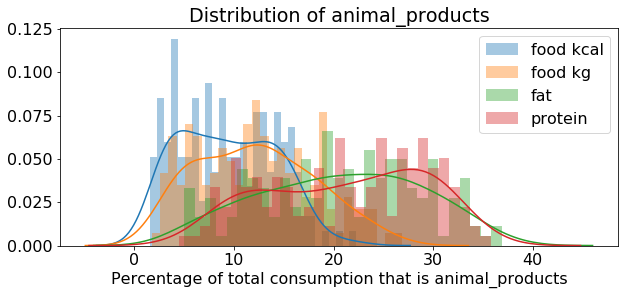

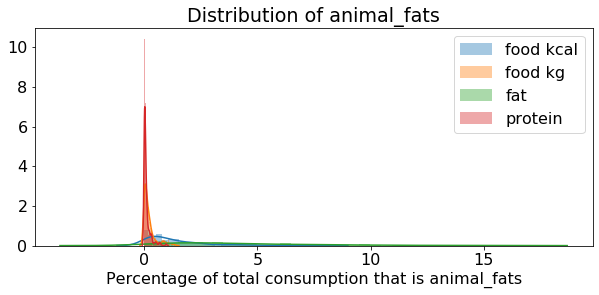

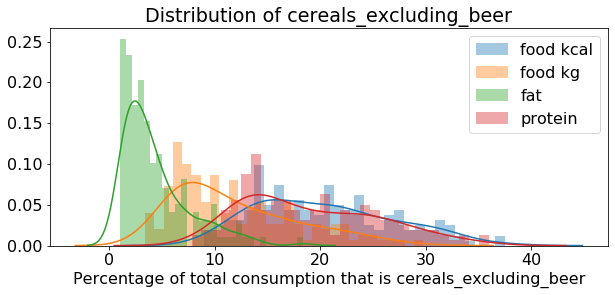

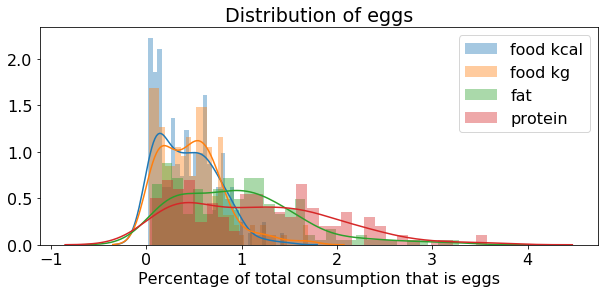

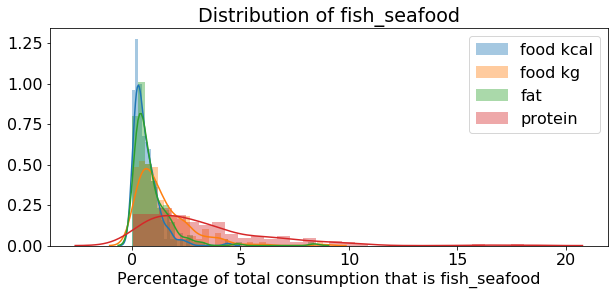

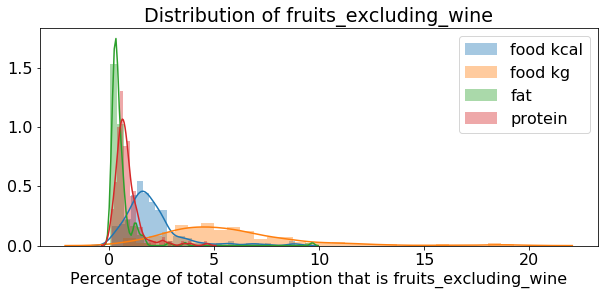

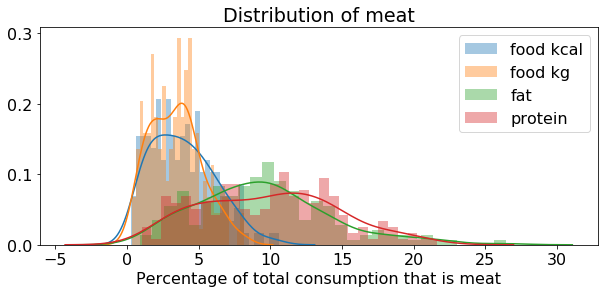

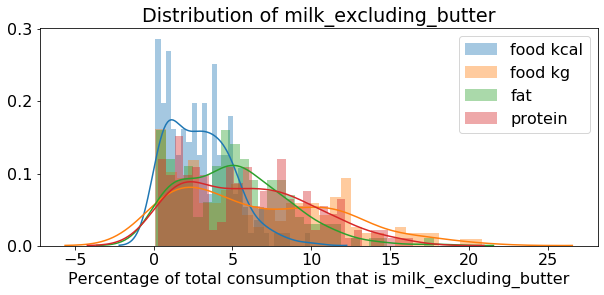

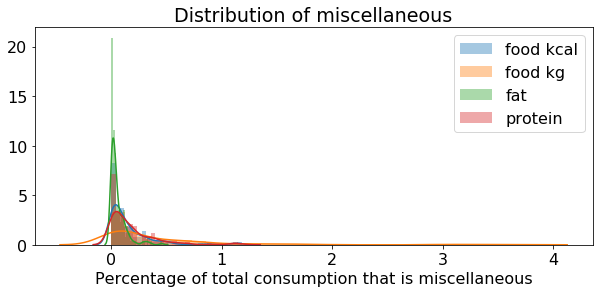

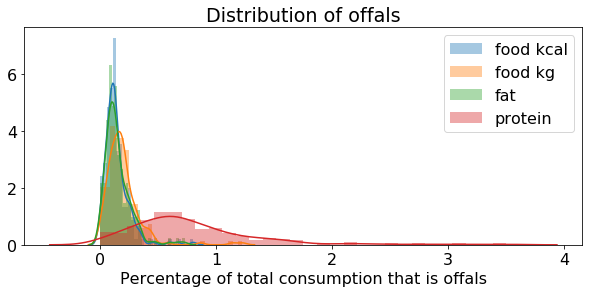

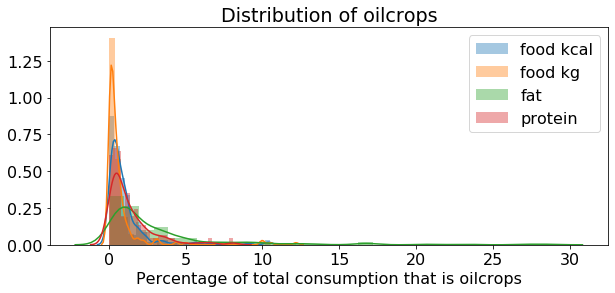

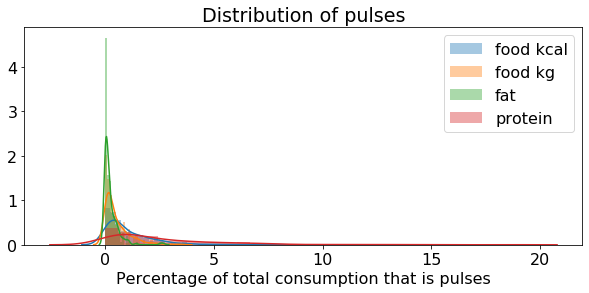

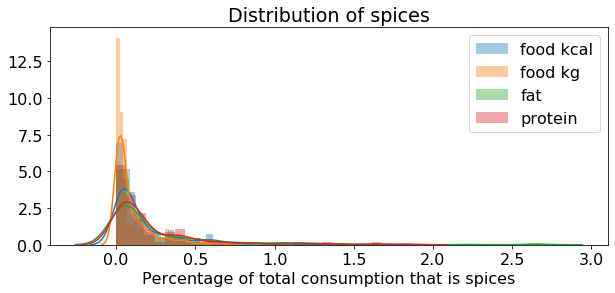

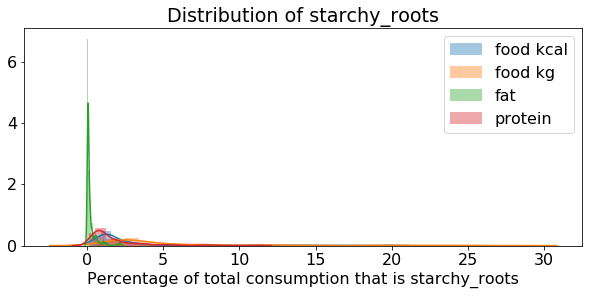

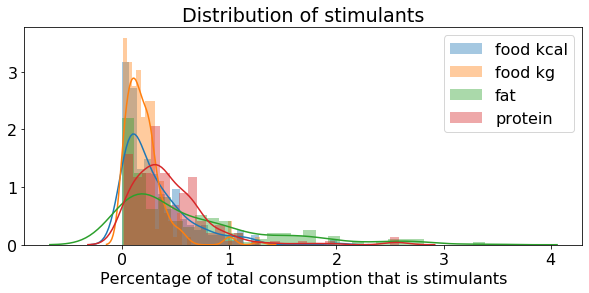

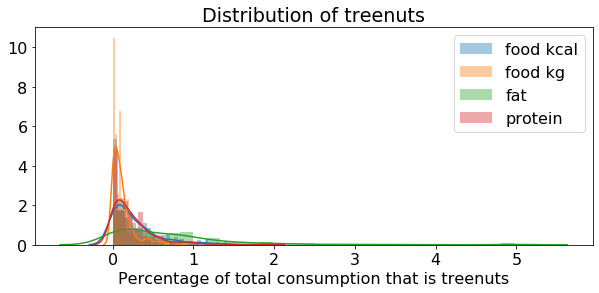

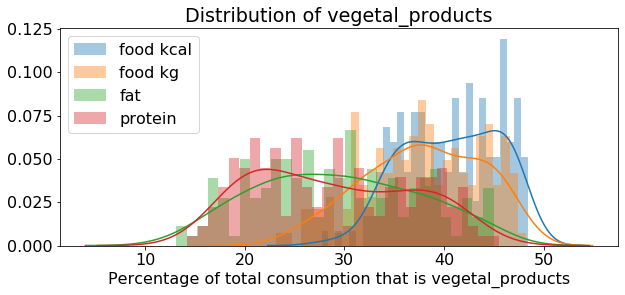

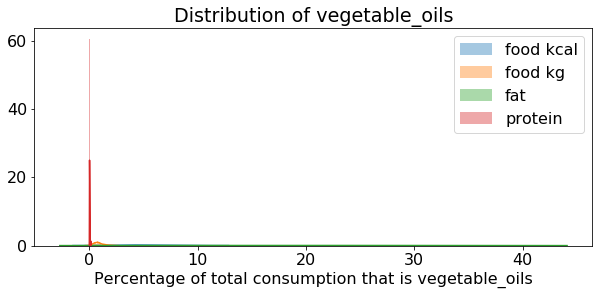

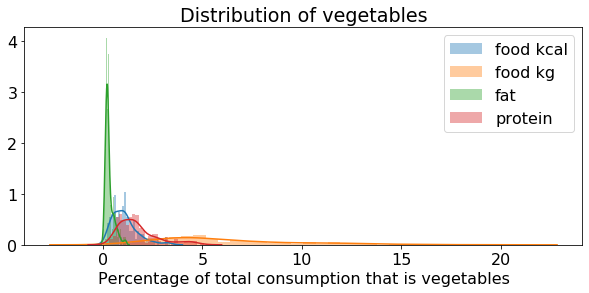

In [13]:
for c in cols_to_visualize:
    visualize_food_subset(c)

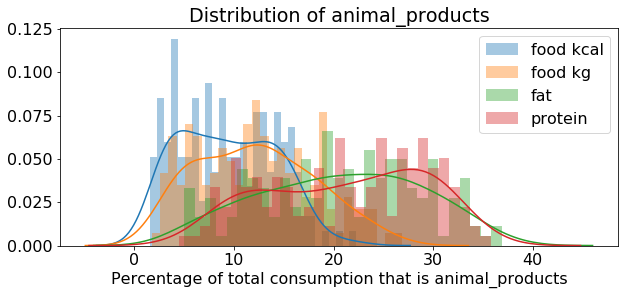

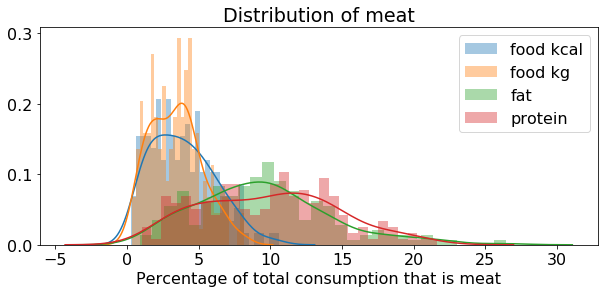

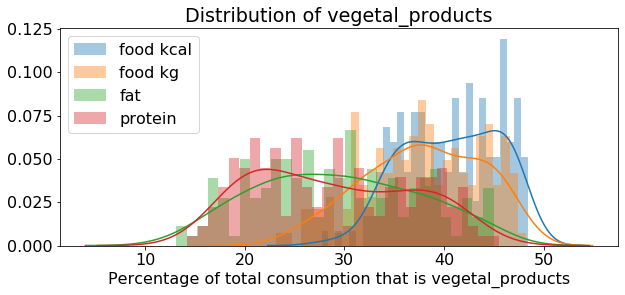

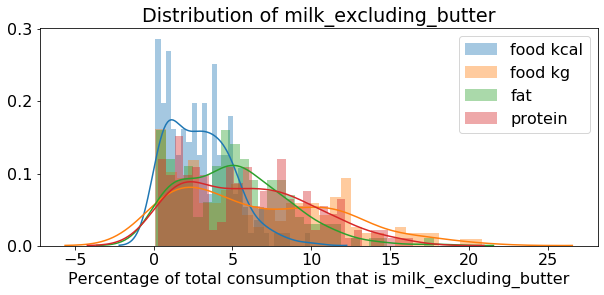

In [14]:
# selecting subset for quick comparison
for c in ['animal_products', 'meat', 'vegetal_products', 'milk_excluding_butter']:
    visualize_food_subset(c)

## Modeling

Coefficient of Determination, Train: 0.857197158624569
Coefficient of Determination, Test: 0.2040381533792276
MSE: 0.00040689978352982626
RMSE: 0.020171757075917465


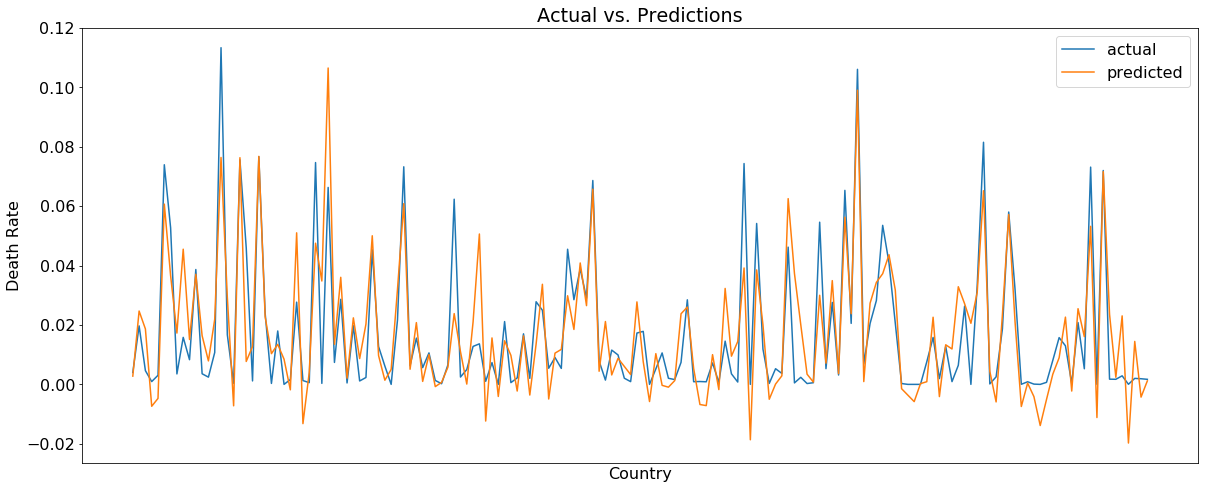

In [15]:
# 5 hidden layers
df, X, y, X_train, X_test, y_train, y_test = split(combined, 'deaths')

clf = MLPRegressor(hidden_layer_sizes=(200, 175, 150, 125, 75), activation = 'relu', solver='lbfgs', max_iter=2000, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Coefficient of Determination, Train:", clf.score(X_train, y_train))
print("Coefficient of Determination, Test:", clf.score(X_test, y_test))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

all_predictions = clf.predict(X)

plt.figure(figsize=(20,8))
plt.plot(df['country'], y, label='actual')
plt.plot(df['country'], all_predictions, label='predicted')
plt.legend()
plt.title('Actual vs. Predictions')
plt.ylabel('Death Rate')
plt.xlabel('Country')
# hide actual country names to prevent graph clutter
plt.tick_params(
    axis='x',
    labelsize=8,
    rotation=90,
top = False,
bottom=False,
labelbottom=False);

Coefficient of Determination, Train: 0.40710018456172037
Coefficient of Determination, Test: 0.3493077186644056
MSE: 0.0003326372357469634
RMSE: 0.01823834520308691


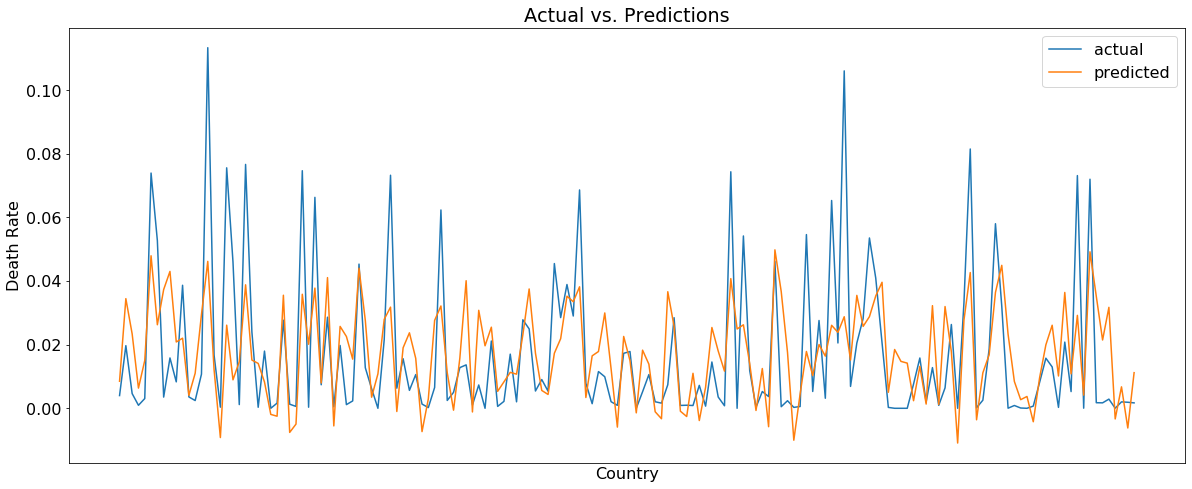

In [16]:
# 7 hidden layers
df, X, y, X_train, X_test, y_train, y_test = split(combined, 'deaths') # using normalized split

clf = MLPRegressor(hidden_layer_sizes=(200, 175, 150, 125, 75, 50, 10), activation = 'relu', solver='lbfgs', max_iter=2000, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Coefficient of Determination, Train:", clf.score(X_train, y_train))
print("Coefficient of Determination, Test:", clf.score(X_test, y_test))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

all_predictions = clf.predict(X)

plt.figure(figsize=(20,8))
plt.plot(df['country'], y, label='actual')
plt.plot(df['country'], all_predictions, label='predicted')
plt.legend()
plt.title('Actual vs. Predictions')
# hide actual country names to prevent graph clutter
plt.tick_params(
    axis='x',
    labelsize=8,
    rotation=90,
top = False,
bottom=False,
labelbottom=False)
plt.xlabel('Country')
plt.ylabel('Death Rate');